<h2 style="text-align:center;font-size:200%;;">Advanced Pyspark for Exploratory Data Analysis </h2>
<h3  style="text-align:center;"><span class="label label-success">Lazy evaluation</span> <span class="label label-success">UDF registering</span> <span class="label label-success">Spark RDD</span> <span class="label label-success">Data Processing</span> <span class="label label-success">Explored Analysis</span> <span class="label label-success">Visualization</span></h3>

## The benefit of learning Pyspark

* If your team are planning to do project with really large dataset, Spark is really great choice because of its power for <font color="red"><b>handling bigdata</b></font> .
Here is the comparision of Pyspark vs Pandas from Databrick:  
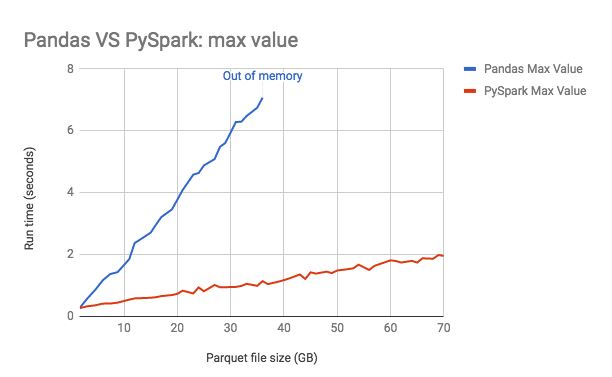
Source: https://databricks.com/blog/2018/05/03/benchmarking-apache-spark-on-a-single-node-machine.html


* If you are planning to <font color="red"><b>land a job</b></font> in a company with really big data ecosystem,  be familiar with Spark will be a <font color="red"><b>good plus</b></font>  and makes you different than other applicants. (that's from my experience)


In case you are new to pyspark, you can check it first,
an introduction guide to Pyspark :https://www.kaggle.com/tientd95/pyspark-for-data-science

<a class="anchor" id="0.1"></a>
[](http://)

# **Table of Contents**


1.	[Initialize pyspark framework and load data into pyspark's dataframe](#1)
2.	[Overview of Dataset](#2)
3.	[Detect missing values and abnormal zeroes](#3)
4.	[Pyspark lazy evaluation](#4)
5.	[Explolatory Data analysis in Pyspark](#5)    
6.	[Unstack pyspark dataframe](#6)
7.	[Pyspark UDF Registering](#7)
8.	[Convert row objects to Spark Resilient Distributed Dataset (RDD)](#8)


# **1. Initialize pyspark framework and load data into pyspark's dataframe** <a class="anchor" id="1"></a>

[Go back to table of contents](#0.1)


The dataset we use is from : Datasource: https://sites.google.com/eng.ucsd.edu/fitrec-project/home 

This dataset is about calculating the heart rate of people, along with other relating features: gender, weather condition, sport type, GPS, etc

In [ ]:
!pip install pyspark;

In [ ]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [ ]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = '../input/fitrec-dataset/endomondoHR.json'
# Load the main data set into pyspark data frame 
df = spark.read.json(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

# **2. Overview of Dataset** <a class="anchor" id="2"></a>

[Go back to table of contents](#0.1)

### Schema, columns & datatypes of the data set:
   *The data set has both single value columns (int, string) and columns made of arrays/list.*

In [ ]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

In [ ]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 2 data rows:')
df.limit(2).toPandas()

# **3. Detect missing values and abnormal zeroes** <a class="anchor" id="3"></a>

[Go back to table of contents](#0.1)

After having a first sight of the columns, the first thing we should check is if the data set having any missing value.
- For string columns, we check for `None` and `null`
- For numeric columns, we check for zeroes and `NaN`
- For array type columns, we check if the array contain zeroes or `NaN`

In [ ]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

In [ ]:
string_columns = ['gender', 'sport', 'url']
numeric_columns = ['id','userId']
array_columns = ['altitude', 'heart_rate', 'latitude', 'longitude', 'speed', 'timestamp']
missing_values = {} 
for index, column in enumerate(df.columns):
    if column in string_columns:    # check string columns with None and Null values
#         missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
#         missing_values.update({column: missing_count})
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
    if column in array_columns:  # check zeros and NaN
        missing_count = df.filter(array_contains(df[column], 0) | array_contains(df[column], np.nan)).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

In [ ]:
# We create new column to count the number of timestamps recorded per row/workout, named as 'PerWorkoutRecordCount' column
df = df.withColumn('PerWorkoutRecordCount', size(col('timestamp')))


# This part is writen as a function to be used again later
def user_activity_workout_summarize(df):
    user_count = format(df.select('userId').distinct().count(), ',d')
    workout_count = format(df.select('id').distinct().count(), ',d')
    activity_count = str(df.select('sport').distinct().count())
    sum_temp = df.agg(functions.sum('PerWorkoutRecordCount')).toPandas()
    total_records_count = format(sum_temp['sum(PerWorkoutRecordCount)'][0],',d')
    columns=['Users count', 'Activity types count','Workouts count', 'Total records count']
    data = [[user_count], [activity_count], [workout_count], [total_records_count]]
    sum_dict = {column: data[i] for i, column in enumerate(columns)}
    sum_df = pd.DataFrame.from_dict(sum_dict)[columns]
    gender_user_count = df.select('gender','userId').distinct().groupBy('gender').count().toPandas()
    gender_activities_count = df.groupBy('gender').count().toPandas()
    gender_user_activity_count = gender_user_count.join(
        gender_activities_count.set_index('gender'), on='gender'
        , how='inner', lsuffix='_gu'
    )
    gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']
    
    return sum_df, gender_user_activity_count

sum_dfs= user_activity_workout_summarize(df)
print('\nOverall data set summary on users, workouts and number of records (pre-filtering):')
sum_dfs[0]

 As we can see, The total records for this dataset is over 111M records. It's really large size

In [ ]:
print('Number of workouts that have less than 50 records and statistic summary:')
removed_df = df.select('PerWorkoutRecordCount').where(df.PerWorkoutRecordCount < 50) \
               .toPandas().describe().astype(int)
removed_df.rename(columns = {'PerWorkoutRecordCount': 'PerWorkoutRecordCount <50'}, inplace=True)
removed_df.T

# **4. Pyspark lazy evaluation** <a class="anchor" id="4"></a>

[Go back to table of contents](#0.1)

Here we will begin to be familiar with some of Advanced Spark feature: **Lazy evaluation**.

<font color="red"><b>Lazy evaluation</b></font> enhances the power of Apache Spark by reducing the execution time of the RDD operations. It maintains the lineage graph to remember the operations on RDD. we can simply remember that all processing in Pyspark is abstraction, When we want to return the results, actually we tell Spark what is the eventual answer you're interested and it figures out best way to get there. As a result, it optimizes the performance and achieves fault tolerance. 

In order to see the result, we have to call Spark.collect(). 

Normolly, we can show the results with the syntax: df.take(k) or df.limit(k) to get the results with k row. 

When K become large number, These 2 way above takes a long time to complete the process. Because this syntax above did not utilize the power of Pyspark processing (Lazy evaluation).
In order to quickly processing , We should use df.collect()[:k] to return the k row as we want.

You can read more about Pyspark lazy evaluation in : https://data-flair.training/blogs/apache-spark-lazy-evaluation/

In [ ]:
ranked_sport_users_df = df.select(df.sport, df.userId) \
    .distinct() \
    .groupBy(df.sport) \
    .count() \
    .orderBy("count", ascending=False)

# Top 5 workout types
highest_sport_users_df = ranked_sport_users_df.limit(5).toPandas()
# Rename column name : 'count' --> Users count
highest_sport_users_df.rename(columns = {'count':'Users count'}, inplace = True)
# Caculate the total users, we will this result to compute percentage later
total_sports_users = ranked_sport_users_df.groupBy().sum().collect()[0][0]

In [ ]:
ranked_sport_users_df.collect()[:5]

# **5. Explolatory Data analysis** <a class="anchor" id="5"></a>

[Go back to table of contents](#0.1)

Let first do some chart indicate the top 5 workout types as we evaluated above

In [ ]:
highest_sport_users_df_renamed = highest_sport_users_df
# Compute the percentage of top 5 workout type / total users
highest_sport_users_df_renamed['percentage'] = highest_sport_users_df['Users count'] \
    / total_sports_users * 100

# We assign the rest of users belong to another specific group that we call 'others'
others = {
      'sport': 'others'
    , 'Users count': total_sports_users - sum(highest_sport_users_df_renamed['Users count'])
    , 'percentage': 100 - sum(highest_sport_users_df_renamed['percentage'])
}

highest_sport_users_df_renamed = highest_sport_users_df_renamed.append(
    others, ignore_index=True
)
print('Top 5 sports that have the most users participated:')
highest_sport_users_df_renamed

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_sport_users_df_renamed['sport']
                     , height=highest_sport_users_df_renamed['Users count'])
title0 =  axs[0].set_title('Users count', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('Sport', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('Users count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_sport_users_df_renamed['sport'] 
                                       ,rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.1)
title1 = axs[1].set_title('User ratio', fontsize = 'small')
plot1 = axs[1].pie(
      x=highest_sport_users_df_renamed['percentage']
    , labels=highest_sport_users_df_renamed['sport']
    , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
    , radius=1
)

text = fig.text(0.5, 1.02, 'Top 5 sports having the most users', ha='center', va='top', transform=fig.transFigure)

The data shows that running, walking and biking-related activities are the most spent by users, which is quite reasonable due to those exercises' convenience without much investment :3

In [ ]:
# Let quick overview activities by gender
# we have something like this
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas() 
activities_by_gender[:5]

# **6. UNSTACK PYSPARK DATAFRAME** <a class="anchor" id="5"></a>
[Go back to table of contents](#0.1)

We want reshape the table above to flatten the gender column so that we can visualize on it. I draw a simple draft as follow 
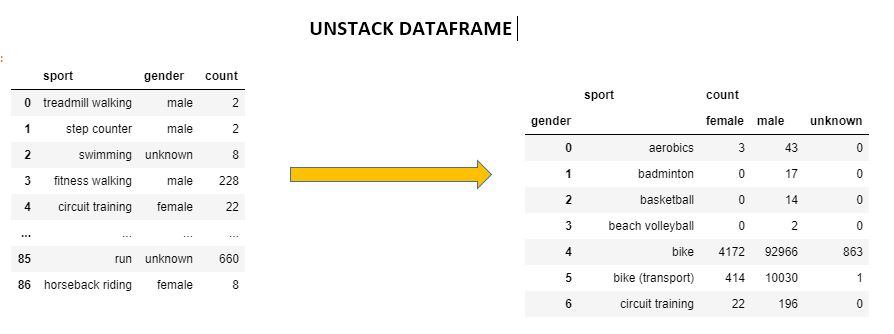

To reshape the table like this in Pyspark, we use 
```python
df.unstack()
```

In [ ]:
total_activities = ranked_sport_users_df.count()
print(f'There are total: {total_activities} activities and here is the chart for activities based on gender:')
# Add the infor of activities based on gender
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas()
# Visualize
fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = activities_by_gender.groupby(['sport', 'gender']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1  ## APPLY UNSTACK TO RESHAPE DATA
                , edgecolor='black', ax=ax, title='List of all activities by gender')
ylabel = plt.ylabel('Sport (Activity)');
xlabel = plt.xlabel('Participation percentage by gender');
legend = plt.legend(
    sorted(activities_by_gender['gender'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

Let's look at the top pareto of 5 sports that have the most participation.

In [ ]:
activities_by_gender_df = activities_by_gender.pivot_table(
    index="sport", columns="gender", values='count', fill_value=0) \
    .reset_index().rename_axis(None, axis=1)

activities_by_gender_df['total'] = activities_by_gender_df['male'] \
        + activities_by_gender_df['female'] \
        + activities_by_gender_df['unknown']
activities_by_gender_df['percentage'] = activities_by_gender_df['total'] \
    / sum(activities_by_gender_df['total']) * 100
top_activities_by_gender_df = activities_by_gender_df.sort_values(
    by='percentage', ascending=False
).head(5)

others = {'sport' : 'others'}
for column in ['female', 'male', 'unknown', 'total', 'percentage']:
    value = sum(activities_by_gender_df[column]) - sum(top_activities_by_gender_df[column])
    others.update({column: value})
top_activities_by_gender_df = top_activities_by_gender_df.append(others, ignore_index=True)
top_activities_by_gender_df = top_activities_by_gender_df.sort_values(
    by='percentage', ascending=False
)
top_activities_by_gender_df

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=top_activities_by_gender_df['sport']
                   , height=top_activities_by_gender_df['total'])
title0 = axs[0].set_title('Workout count', fontsize='small')
xlabel0 = axs[0].set_xlabel('Sport', fontsize='small')
ylabel0 = axs[0].set_ylabel('Workout count (times)', fontsize='small')
xsticks_label = axs[0].set_xticklabels(top_activities_by_gender_df['sport']
                                       , rotation='vertical', fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.3)
title1 = axs[1].set_title('Workout ratio', fontsize = 'small')
plot1 = axs[1].pie(
    x=top_activities_by_gender_df['percentage']
    , labels=top_activities_by_gender_df['sport']
    , autopct='%1.1f%%', shadow=True, explode=explode, radius=1
)

text = fig.text(0.5, 1.02, 'Top 5 sports that were most participated'
                , ha='center', va='top', transform=fig.transFigure)

Once again, similar to the user participation, running, walking and biking are also the dominant contribution interm of number of workout counts. However, the only different is that pure running and biking activities count is much bigger than those of the remaining sports, and the total count of those 2 already take up to more than 85% of total activities. 

Let play with some question such as how many people participated in more than 1 sport.

In [ ]:
min_number_of_sports = 1

sport_df = df \
    .select(df.userId, df.gender, df.sport) \
    .distinct() \
    .groupBy(df.userId, df.gender) \
    .count()    

user_more_sports_df = sport_df \
                    .filter(sport_df["count"] > min_number_of_sports) \
                    .orderBy("count", ascending = False) \
                    .toPandas()
user_more_sports_df.rename(columns = {'count':'Sports count'}, inplace = True)
user_more_sports_df.describe().astype(int).T

*Based on the summary, there are 822 persons participated more than 1 sport. Among them in average a person take part in about 3 sports and there is some person playing up to 16 sports!* <br />
Now we look at the statistic by gender in box plot:

In [ ]:
plot = user_more_sports_df.boxplot(column='Sports count', by='gender', fontsize='small', figsize=(6,7))

*The boxplot showed that except the outliers, both males and females have nearly the same distribution of sport participation.*

### Distribution of records count per workout

*For a more detailed observation, we break down the record count per activity into each individual sport. <br />Based on the distribution, the maximum records per workout is 500, but not all workouts and sport types reach that number.*

In [ ]:
print('\nPlot of workouts distribution by activity type:')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 + 3, plot_size_y * 13 + 1
figsize=(figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
#fig, ax = plt.subplots()
PerWorkoutRecordCount_dist = df.select('PerWorkoutRecordCount', 'sport').toPandas().hist(
    column='PerWorkoutRecordCount', bins=10, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small', by='sport', ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Distribution of records count per workout by sport', ha='center' 
         , fontsize='small', transform=fig.transFigure);
xlabel = fig.text(
    0.5, 0.01, '# of records/workout', va='bottom', ha='center', transform=fig.transFigure
)
ylabel = fig.text(0.01, 0.5, 'Frequency (count)', va='center', rotation='vertical');

In [ ]:
# Filter df with at least 10 records (as we are assumming if any user_id with less then 10 record would not be meaningful)
qualified_df = df \
    .select(df.sport, df.userId, df.gender) \
    .groupBy(df.sport, df.userId, df.gender) \
    .count()
qualified_df = qualified_df.filter(qualified_df["count"] >= 10) \
    .orderBy("count", ascending = False)

In [ ]:
print('Number of users having more than 10 workouts:')
qualified_pd_df = qualified_df.select("userId", "gender").distinct() \
    .groupBy(qualified_df.gender).count().toPandas()
qualified_pd_df.rename(columns={'count': 'Users count'}, inplace=True)
qualified_pd_df
qualified_users_count = sum(qualified_pd_df['Users count'])
total_users_count = df.select('userId').distinct().count()
qualified_percentage = round((qualified_users_count / total_users_count),2) * 100
print('\nSo there is {} / {} of users qualifying the 10 historical records criteria, which is {:.2f}%' \
      .format(qualified_users_count, total_users_count, qualified_percentage)
     )

# **7. Pyspark UDF Registering** <a class="anchor" id="6"></a>
[Go back to table of contents](#0.1)


To be in short, Registering UDF to Pyspark is the process of **turning Python Functions into PySpark Functions (UDF)**

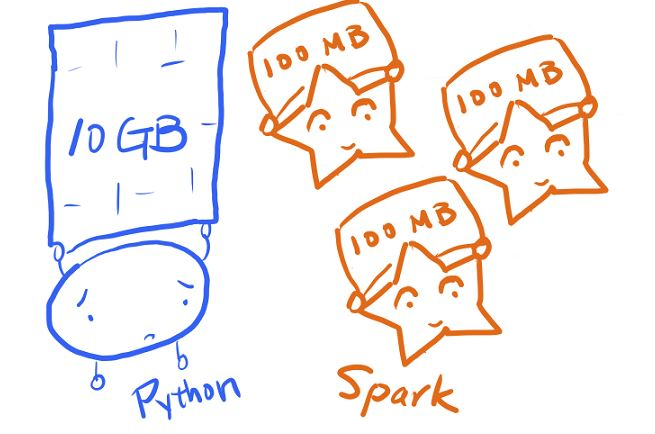

When we run the code on Spark clusters, this technique will speed up the process and save valuable executed time.

To learn more about Pyspark UDF, you can visit https://changhsinlee.com/pyspark-udf/

Okie now we will start to apply registering python function to UDF in the 'timestamp' column

 
This column is very important if we use this dataset to predict something, like predict heart rate to soonly detect some bad signal on user's heart. Because this is a type of time series analysis, so we will look at the `timestamp` column carefully.
### Creating some new features from `timestamp`
As seen before `timestamp` column contains records of timestamp series of a single workout (a data row) and is stored in UNIX timestamp format. To have more insights on this column, we will create 4 more new columns from it:  
- `date_time`: Convert UNIX timestamp into python's datetime format   
- `duration`: Total time of a single workout, in minute    
  *In order to get the workout `duration`, we get the difference between max and min of the datetime list of each workout.*
- `workout_start_time`: Determine when, which hour of the day a workout start  
  *For `workout_start_time`, it's the hour part of the first datetime record of a workout.*
- `interval`: List of time lapses between each single timestamp record in a single workout, in second   
  *And for `interval`, we will calculate it by taking the difference between 2 consecutive timestamp records within a workout.*

In order to attach these 4 features to SparkdDataFrame, we register them with PYSPARK UDF 

```python
function_to_udf = udf(function, Datatype()) 

# Datatype() can be floattype(), TimestampType(), etc

```


In [ ]:
# LOOK AGAIN THE TIMESTAMP COLUMN
df.limit(3).toPandas()

### We create 4 helper function for 'timestamp' column as described above then convert them to UDF

In [ ]:
# Convert a timestamp column into Datetime.Datetime, to be used for .withColumn function later
def to_time(timestamp_list):
    # convert to datetime and minus 7 hours due to the difference in Endomondo time window with utc time as the dataset description
    return [datetime.fromtimestamp(t) - timedelta(hours=7) for t in timestamp_list]

# Register 'to_time' function into UDF pyspark framework
udf_to_time = udf(to_time, ArrayType(elementType=TimestampType()))

# Support function to get the duration (in minutes) of a list of datetime values, to be used for withColumn function later
def get_duration(datetime_list):
    time_dif = max(datetime_list) - min(datetime_list)
    return time_dif.seconds/60

# Register the support function 'get_duration' as a user defined function into pyspark framework
udf_get_duration = udf(get_duration, FloatType())

# Support function to get the workout start time of the datetime list, to be used for withColumn function later
def get_start_time(datetime_list):
    return min(datetime_list)

# Register the support function 'get_start_time' as a user defined function into pyspark framework
udf_get_start_time = udf(get_start_time, TimestampType())

# Support function to get list of intervals within a workout
def get_interval(datetime_list):
    if len(datetime_list) == 1:
        return [0]
    else:
        interval_list = []
        for i in range(0, len(datetime_list)-1):
            interval = (datetime_list[i+1] - datetime_list[i]).seconds
            interval_list.append(interval)
        return interval_list

# Register the support function 'get_interval' as a user defined function into pyspark framework    
udf_get_interval = udf(get_interval, ArrayType(elementType=IntegerType()))

# Create new 'date_time' column to convert from timestamp into python's datetime format for later usage
df = df.withColumn('date_time', 
    udf_to_time('timestamp'))

# Create 'workout_start_time' column to get the start time of each workout/row:
df = df.withColumn('workout_start_time', hour(udf_get_start_time('date_time')))

# Create duration column from the date_time column just created, using the udf function udf_get_duration defined above
df = df.withColumn('duration', udf_get_duration('date_time'))

# Create interval column from the date_time column, using the udf function udf_get_interval defined above
df = df.withColumn('interval', udf_get_interval('date_time'))

print('New columns (''date_time'', ''workout_start_time'' in hour\
, ''duration'' in minutes & ''interval'' in seconds)\n, first 5 rows:')
df.select('timestamp','date_time', 'workout_start_time', 'duration', 'interval').limit(5).toPandas()



### Now, we look at the duration of each workout (in minutes). First is some typical statistics.

In [ ]:
print('\nLet''s look at the statistics of the new duration column (in minutes):')
df.select('duration').toPandas().describe().T

From the statistic of `duration` column, it can be observed that workout duration can last from 0 minute and up to 1 full day (1440 minutes = 24 hours). The duration of 0 might be for workouts that only have 1 single record only, so the min and the max timestamp would be the same.<br />
Now it's plot time for duration:


In [ ]:

print('\nPlotting distribution of duration per sport type:')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 +3, plot_size_y * 13 + 1
figsize = (figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)

duration_dist = df.select('duration', 'sport').toPandas().hist(
    column='duration', by='sport', bins=15, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small' , ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Distribution of workout duration by sport'
             , ha='center', va='center', transform=fig.transFigure
            )
xlabel = fig.text(0.5, 0.01, 'Workout duration (minutes)'
             , ha='center', va='center', transform=fig.transFigure)
ylabel = fig.text(0.01, 0.5, 'Frequency (count)', va='center', rotation='vertical');

*From the duration summary & distribution plot, majority of the activities happens in 1-2 hours, only a few sports with a few cases each type happened in longer durations, such as moutain bike, hiking, sailing, etc..*

# **8. Convert row objects to Spark Resilient Distributed Dataset (RDD)** <a class="anchor" id="7"></a>
[Go back to table of contents](#0.1)

In this plot, we will practice how to convert the row object to RDD format in Pyspark through:

```python
rdd = df.rdd.map(tuple)
or
rdd = df.rdd.map(list)
```

The advanced of RDD format is: Each data set is divided into logical parts and these can be easily computed on different nodes of the cluster. They can be operated in parallel and are fault-tolerant, so that the process is stable and very fast

If we run this code such as on Zeppelin which intergrated with Pyspark clusters,we can see how speed RDD spark is.

RDD is very important concept in Spark and you can deep into more in here :
https://www.educba.com/what-is-rdd/

To practice this concept, we look at the `interval` column and have some statistics for it. we will calculate some major statistics (min/max/mean/average/standar deviation and 4 quantiles 25th/50th/75th/95th) info in pySpark, convert to Rdd and plot them.



In [ ]:
#  Helper function to calculate statistic(s) of the column name from a tuple x of (sport, records list of the column)
#, the stats to calculate is also given as an input
def calculate_stats(x,column_name, stat_list):
    sport, records_list = x
    stat_dict = {'sport': sport}
    if 'min' in stat_list:
        min_stat = min(records_list)
        stat_dict.update({'min ' + column_name : min_stat})
    if 'max' in stat_list:
        max_stat = max(records_list)
        stat_dict.update({'max ' + column_name: max_stat})
    if 'mean' in stat_list:
        average_stat = stats.mean(records_list)
        stat_dict.update({'mean ' + column_name: average_stat})
    if 'stdev' in stat_list:
        std_stat = stats.stdev(records_list)
        stat_dict.update({'stdev ' + column_name: std_stat})
    if '50th percentile' in stat_list:
        median_stat = stats.median(records_list)
        stat_dict.update({'50th percentile ' + column_name: median_stat})
    if '25th percentile' in stat_list:
        percentile_25th_stat = np.percentile(records_list, 25)
        stat_dict.update({'25th percentile ' + column_name: percentile_25th_stat})
    if '75th percentile' in stat_list:
        percentile_75th_stat = np.percentile(records_list, 75)
        stat_dict.update({'75th percentile ' + column_name: percentile_75th_stat})
    if '95th percentile' in stat_list:
        percentile_95th_stat = np.percentile(records_list, 95)
        stat_dict.update({'95th percentile ' + column_name: percentile_95th_stat})
    return stat_dict

def to_list(a):
    return a

def extend(a, b):
    a.extend(b)
    return a

def retrieve_array_column_stat_df(df, column_name, stat_list):
    # Convert sport & "column_name" to RDD to easily calculate the statistics of intervals by sports
    sport_record_rdd = df.select('sport', column_name).rdd \
    .map(tuple).combineByKey(to_list, extend, extend).persist()

    # Calculate statistics of the input column by calling calculate_stats function defined above
    record_statistic_df = pd.DataFrame(sport_record_rdd.map(
        lambda x: calculate_stats(x, column_name,stat_list)).collect()
                                      )
    # Set proper dataframe column orders
    columns_order = ['sport'] + [stat + ' ' + column_name for stat in stat_list]
    # Re order columns
    return record_statistic_df[columns_order]

stat_list = ['min', '25th percentile', 'mean', '50th percentile',
                     '75th percentile', '95th percentile', 'max', 'stdev']
interval_statistic_df = retrieve_array_column_stat_df(df, column_name='interval', stat_list=stat_list)
print('\nLet\'s look at statistic for interval, in seconds (by sport):' )
interval_statistic_df

Now we plot those numbers in bar (for quantiles statistics) and line charts (for min/max/mean/stdev) for a more visualized feel.  
*Note: Due to the fact that the maximum interval and stdev have a much higher order of magnitude compared to the remaining columns, we need to put those 2 columns in a separate y axis on the right.*

In [ ]:
print('\nSummarize statistics of interval sport:')
bar_columns = ['25th percentile interval', '50th percentile interval'
               , '75th percentile interval', '95th percentile interval']
line_columns1 = ['min interval', 'mean interval'] 
line_columns2 = ['max interval', 'stdev interval'] 
interval_statistic_df = interval_statistic_df.sort_values(
    by='95th percentile interval', ascending=False
)
figsize=(13, 59)
fig, axs = plt.subplots(nrows=7, figsize=figsize)

d = axs[0].set_title('Interval statistics by sport', fontsize=18)
for i in range (7):
    interval_statistic_sub_df = interval_statistic_df.iloc[i*7:i*7+7,]
    #interval_statistic_sub_df
    plot1 = interval_statistic_sub_df[['sport'] + bar_columns] \
        .groupby(['sport']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i], 
    )
    plot2 = interval_statistic_sub_df[['sport'] + line_columns1].plot(x='sport', ax=axs[i], marker='o')
    ax2 = axs[i].twinx()
    plot3 = interval_statistic_sub_df[['sport'] + line_columns2].plot( x='sport', ax=ax2, marker='o', color=['m', 'g'])
    a = axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.5), frameon=False)
    a = ax2.legend(  labels=['max interval (right)', 'stdev interval (right)']
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(interval_statistic_sub_df['sport'],rotation = 'horizontal', fontsize='small')
    c = axs[i].set_xlabel('Sport (Activity)', fontsize='small');
    d = axs[i].set_ylabel('Quantiles Statistics + min/mean\n(second)', fontsize=16);
    e = ax2.set_ylabel('Max/stdev Statistics\n(second)', fontsize=16)
    for tick in axs[i].yaxis.get_major_ticks():
        a = tick.label.set_fontsize(16) 
    ax2.tick_params(axis='y', labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.2)
plt.show();


Looking at the quantiles statistic, up to 95% of the interval data set does not have the interval larger than 400 seconds, while there are just a few outliers that made the maximum intervals reach up to 86400 seconds (a full days).

### Workout start time
Once again, we use histogram chart to look at the distribution of workouts' started hours, grouped by sport and broken down by gender. We divide a day into intervals of 2 hours, so there are totally 12 buckets.

In [ ]:
# Retrive the table of gender, sport and workout_start_time for plotting
start_time_df = df.select('gender', 'sport','workout_start_time').toPandas()

In [ ]:
activities = start_time_df['sport'].unique()
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = (plot_size_x + 0.5) * 4 +3, (plot_size_y + 1) * 13 + 1


nrows, ncols = 13, 4
a = fig.subplots_adjust(hspace = 1, wspace = 1)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize_x, figsize_y))
print('\nPlotting distribution of workout start time per sport type, break down by gender:')
a = plt.setp(axs, xticks=[0, 4, 8, 12, 16, 20])
for index, sport in enumerate(activities):
    row_index, col_index = divmod(index, ncols)
    male_start_time_list = start_time_df[(start_time_df.sport == sport) & 
                                            (start_time_df.gender == 'male')]['workout_start_time']
    female_start_time_list = start_time_df[(start_time_df.sport == sport) & 
                                            (start_time_df.gender == 'female')]['workout_start_time']
    unknown_start_time_list = start_time_df[(start_time_df.sport == sport) & 
                                            (start_time_df.gender == 'unknown')]['workout_start_time']
    if len(male_start_time_list) > 0:
        male_dist = axs[row_index, col_index].hist(male_start_time_list,
                                      bins = 12, alpha=0.5, label='male', range=(0, 23))
    if len(female_start_time_list) > 0:    
        female_dist = axs[row_index, col_index].hist(female_start_time_list,
                                      bins = 12, alpha=0.5, label='female', range=(0, 23))
    if len(unknown_start_time_list) > 0:
        unknown_dist = axs[row_index, col_index].hist(unknown_start_time_list,
                                      bins = 12, alpha=0.5, label = 'unknown', range=(0, 23))
    b= axs[row_index, col_index].set_title('Activitiy: ' + sport, fontsize='small')
    a = axs[row_index, col_index].legend(loc="upper left", fontsize='small')
    a = plt.setp(axs[row_index, col_index].get_xticklabels(), fontsize='small')

for i in range(1,4):
    x = axs[12, i].set_visible(False)
a = fig.tight_layout()
z = fig.text(0.5, 1, 'Distribution of workout started time (hour) by sport'
             , ha='center', va='top', transform=fig.transFigure)
y = fig.text(0.5, 0.01, 'Workout started hour in a day (hour)'
             , ha='center', va='bottom', transform=fig.transFigure)
z = fig.text(0.02, 0.5, 'Frequency (count)', va='center', rotation='vertical');

From the distribution charts above, it can be seen that most of the sports have activities started either in the morning or eveneing (bimodal distribution), which does make sense. There are a few activities happening during the timeframe of 0-4 o'clock, which is quite odd.  
<br />

### Look deeper into row level information

In [ ]:
stat_list = ['min', '25th percentile', 'mean', '95th percentile', 'max', 'stdev']
heart_rate_statistic_df = retrieve_array_column_stat_df(df, column_name='heart_rate', stat_list=stat_list)

*Due to the huge amount of users and workout numbers, we just picked randomly up to a x number of users per gender (ex, 5), and up to y workouts per activity type (ex, 10).<br />*

In [ ]:
# Support function helping to sample data
def sampling_data(max_users_per_gender, max_workouts_per_sport):
    '''
        max_users_per_gender: maximum number of user to be selected randomly per gender
        max_workouts_per_sport: maximum number of activities to be selected per sport 
        (the sports existing in selected users)
    '''
    # Get unique list of userId and gender, for sampling purpose
    users_genders = df.select('userId', 'gender').distinct().toPandas()
    # Use 'sample' function to pick up to 3 userId per gender from the unique userId list
    random_x_users_per_gender = users_genders.groupby('gender')['userId'].apply(
                lambda s: s.sample(min(len(s), max_users_per_gender))
    )

    # Apply filter on the main pyspark dataframe for sampling
    samples_by_gender = df.where(df.userId.isin(list(random_x_users_per_gender)))

    # Next, generate the unique activity ids and sport types list from the sampled data set 
    workout_sports = samples_by_gender.select('id', 'sport').distinct().toPandas()
    # Use 'sample' function to pick up to 10 activity ids for each kind of sport 
    random_y_workouts_per_sport = workout_sports.groupby('sport')['id'].apply(
        lambda s: s.sample(min(len(s), max_workouts_per_sport))
    )

    # Apply filter to the sampled dataset to continue reduce the number of workouts per activity type
    samples_by_gender_and_sport = samples_by_gender.where(df.id.isin(list(random_y_workouts_per_sport)))
    return samples_by_gender_and_sport

In [ ]:
# Use 2 variable to determine the sampling criteria: 
# maximum users per gender and maximum workouts per sport
max_users_per_gender, max_workouts_per_sport = 20, 15

# Collect the sampled data set to Pandas to be used with plot features
pd_df = sampling_data(max_users_per_gender, max_workouts_per_sport).toPandas()
print('\nSampled data overview (only string and numeric columns):')
pd_df.describe()

we will normalize the time for all workouts by calulating the duration (in seconds) of each timestamp record from the first record of a workout (the first datetime element of the list in that workout). <br />
Then we plot the heart rate on this normalized time, grouping by sport.

In [ ]:
# Lambda function to flatten a list of lists into a big single list
flattern = lambda l: set([item for sublist in l for item in sublist])

normalized_datetime_list = []
for index,data_row in pd_df.iterrows():
    min_date_time = min(data_row['date_time'])
    normalized_datetime_list.append(
        [(date_time - min_date_time).seconds for date_time in data_row['date_time']]
    )

pd_df['normalized_date_time'] = normalized_datetime_list

print('New normalized datetime (first 7 rows):')
pd_df.head(7)[['userId', 'sport', 'date_time','normalized_date_time']]

print('\nPlot raw heart rate (sampled) by normalized time:')

sport_list = pd_df['sport'].unique()
# Define the length of the figure dynamically depends on the length of the sport list
fig, axs = plt.subplots(len(sport_list), figsize=(15, 6*len(sport_list)))
subplot_adj = fig.subplots_adjust(hspace = 0.6)
plot_setp = plt.setp(axs, yticks=range(0,250,20))

for sport_index, sport in enumerate(sport_list):
    workout = pd_df[pd_df.sport == sport]
    max_time = max(flattern(workout.normalized_date_time))
    for workout_index, data_row in workout.iterrows():
        label = 'user: ' + str(data_row['userId']) + ' - gender: ' + data_row['gender']
        plot_i = axs[sport_index].plot(
            data_row['normalized_date_time'], data_row['heart_rate'], label=label
        )
    title_i = axs[sport_index].set_title('Activitiy: ' + sport, fontsize='small')
    xlabel_i = axs[sport_index].set_xlabel('Time (sec)', fontsize='small')
    xsticklabels_i = axs[sport_index].set_xticklabels(
        range(0, max_time, 500),rotation = 'vertical', fontsize=9
    )
    ysticklabels_i = axs[sport_index].set_yticklabels(range(0,250,20),fontsize='small')
    legend_i = axs[sport_index].legend(
        loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 9}
    )

x_label = fig.text(0.04, 0.5, 'Heart rate (bpm)', va='center', rotation='vertical')
chart_title = fig.text(0.5, 1.3, 'Raw heart rate (sample) by normalized time', 
            ha='center', va='center', fontsize='small', transform=axs[0].transAxes)


### Workout displacements
We will have some visualization on 3 displacement/geometry info columns (`longitude`,`latitude` & `altitude`).    
Since the geometry location of each user and workout is different from each others, we only plot a few single workouts in 3D plots to have a look on the workout route.


In [ ]:
pd_df_small = sampling_data(max_users_per_gender=2, max_workouts_per_sport=2).toPandas()
print('Sampled data (2 user, 2 workouts per sport):')
pd_df_small[['userId', 'gender','sport','id', 'workout_start_time'
             ,'PerWorkoutRecordCount', 'duration', 'longitude', 'latitude', 'altitude']].describe()

In [ ]:
def get_fixed_mins_maxs(mins, maxs):
    deltas = (maxs - mins) / 12.
    mins = mins + deltas / 4.
    maxs = maxs - deltas / 4.

    return [mins, maxs]

workout_count = pd_df_small.shape[0]
ncols = 3
nrows = math.ceil(workout_count/ncols)
#workout_count
fig = plt.figure(figsize=(8 * (ncols + 0.5), 8*nrows))

a = fig.subplots_adjust(hspace = 0.2, wspace=0.5)
#c = plt.setp(axs, yticks=range(0,250,20))

print('Plot workout path in 3D graphs per each workout:')
for row_index, row in pd_df_small.iterrows():
    if row_index==2:
        text = ax.text2D(
            0.01, 1, "Workout path (longitude/latitude/altitude)"
            , fontsize=18, transform=ax.transAxes
        )
    min_long = min(row['longitude']) - stats.stdev(row['longitude'])
    max_long = max(row['longitude']) + stats.stdev(row['longitude'])
    minmax_long = get_fixed_mins_maxs(min_long, max_long)
    #minmax_long
    min_lat = min(row['latitude']) - stats.stdev(row['latitude'])
    max_lat = max(row['latitude']) + stats.stdev(row['latitude'])
    minmax_lat = get_fixed_mins_maxs(min_lat, max_lat)
    #minmax_lat
    min_alt = min(row['altitude']) - stats.stdev(row['altitude'])
    max_alt = max(row['altitude']) + stats.stdev(row['altitude'])
    minmax_alt = get_fixed_mins_maxs(min_alt, max_alt)
    #minmax_alt
    ax = fig.add_subplot(nrows, ncols, row_index + 1, projection='3d')
    title = 'Activitiy: ' + row['sport'] + ' - Gender: ' + row['gender'] \
        + '\nRecords: ' + str(int(row['PerWorkoutRecordCount'])) \
        + ' - Duration: ' + str(int(row['duration'])) + ' minutes'
    title = ax.set_title(title, fontsize=16)
    scatter = ax.scatter(row['longitude'], row['latitude'], row['altitude'], c='r', marker='o')
    plot = ax.plot3D(
        row['longitude'], row['latitude'], row['altitude'], c='gray', label='Workout path'
    )
    
    x_label = ax.set_xlabel('Longitude (Degree)', fontsize=16)
    y_label = ax.set_ylabel('Latitude (Degree)', fontsize=16)
    z_label = ax.set_zlabel('Altitude (m)', fontsize=16, rotation = 0)
    for t in ax.xaxis.get_major_ticks():
        font_size = t.label.set_fontsize(16)
    for t in ax.yaxis.get_major_ticks():
        font_size = t.label.set_fontsize(16)
    for t in ax.zaxis.get_major_ticks():
        font_size = t.label.set_fontsize(16)
    legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.zaxis.set_rotate_label(False)
    #b = plt.setp(ax.get_xticklabels(), rotation=41)
    #b = plt.setp(ax.get_yticklabels(), rotation=-30)
    plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
    plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
    ax.pbaspect = [4, 2, 0.5]
    xlims = ax.set_xlim(minmax_long)
    ylims = ax.set_ylim(minmax_lat)
    # Some sports will not have altitude change so check it before set z limit
    if minmax_alt[0] != minmax_alt[1]: zlims = ax.set_zlim(minmax_alt)
    # Do this trick to enable tight_layout for 3D plot:
    for spine in ax.spines.values():
        b = spine.set_visible(False)
plt.rcParams['legend.fontsize'] = 16
a = plt.tight_layout()
plt.show()

Thank you for reading my work, wish you strong and stay safe